

## **Milstone 3 - Hubble Tension**

## **First Model**

In [1]:
import numpy as np
import matplotlib.pyplot as plt


# pandas
import pandas as pd

# keras library
from keras.models import Sequential
import keras
from keras.layers import Dense

# scikit functions
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

In [2]:
dataset = pd.read_csv("Pantheon.csv")

dataset.head()

,Name,zcmb,zhel,dz,mb,dmb
0,03D1au,0.50309,0.50309,0.0,22.93445,0.12605
1,03D1ax,0.49480,0.49480,0.0,22.88020,0.11765
2,03D1co,0.67767,0.67767,0.0,24.03770,0.20560
3,03D1ew,0.86650,0.86650,0.0,24.34685,0.17385
4,03D1fq,0.79857,0.79857,0.0,24.36050,0.17435


In [3]:
dataset = dataset.drop(['dz', 'zhel', 'Name'], axis=1)
dataset.head()

,zcmb,mb,dmb
0,0.50309,22.93445,0.12605
1,0.49480,22.88020,0.11765
2,0.67767,24.03770,0.20560
3,0.86650,24.34685,0.17385
4,0.79857,24.36050,0.17435


In [4]:
y = dataset['mb']
X = dataset.drop('mb',axis=1)

In [5]:
from sklearn.model_selection import train_test_split

x_train , x_test , y_train , y_test = train_test_split(X, y,test_size=0.33)

In [6]:
N , D =x_train.shape
print(x_train.shape)
print('N',N)
print('D',D)

(684, 2)
N 684
D 2


In [7]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [8]:
model = Sequential([keras.layers.Input(shape=(D,)),
                    keras.layers.Dense(128, activation = 'relu', kernel_initializer='normal'),
                    keras.layers.Dense(64, activation = 'relu', kernel_initializer='normal'),
                    keras.layers.Dense(16, activation = 'relu', kernel_initializer='normal'),
                    keras.layers.Dense(1 , activation = 'linear')])

In [9]:
from keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(monitor="mean_squared_error", patience=40, verbose=1, mode='auto')


def lr_scheduler(epoch, lr):
    decay_rate = 0.1
    decay_step = 90
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr


callbacks = [keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1), earlystopping]

In [10]:
model.compile(optimizer='rmsprop',loss='mean_squared_error', metrics=['mean_absolute_error', 'mean_squared_error'])

In [11]:
%%time
bc = model.fit(x_train , y_train , validation_split=0.2,epochs=100, callbacks = [callbacks] )


Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100
18/18 [==============================] - 2s 23ms/step - loss: 416.3852 - mean_absolute_error: 20.2388 - mean_squared_error: 416.3852 - val_loss: 386.5364 - val_mean_absolute_error: 19.5152 - val_mean_squared_error: 386.5364 - lr: 0.0010

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/100
18/18 [==============================] - 0s 5ms/step - loss: 324.9633 - mean_absolute_error: 17.8092 - mean_squared_error: 324.9633 - val_loss: 253.8209 - val_mean_absolute_error: 15.7421 - val_mean_squared_error: 253.8209 - lr: 0.0010

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/100
18/18 [==============================] - 0s 5ms/step - loss: 172.8276 - mean_absolute_error: 12.6763 - mean_squared_error: 172.8276 - val_loss: 100.3707 - val_mean_absolute_error: 9.4381 - val_mean_squared_error: 100.3707 - lr: 0.0010

Epo

In [12]:
%%time
model.evaluate(x_test, y_test)

11/11 [==============================] - 0s 3ms/step - loss: 0.1251 - mean_absolute_error: 0.2678 - mean_squared_error: 0.1251
CPU times: user 83.4 ms, sys: 3.85 ms, total: 87.2 ms
Wall time: 135 ms


[0.1251300424337387, 0.2677958309650421, 0.1251300424337387]

In [13]:
history = bc.history

In [14]:
history.keys()

dict_keys(['loss', 'mean_absolute_error', 'mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_mean_squared_error', 'lr'])

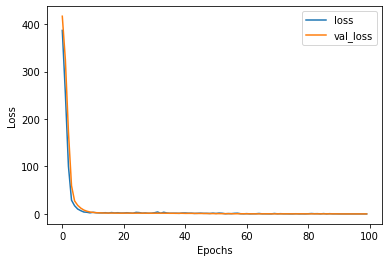

In [15]:
losses = history['loss']
val_losses = history['val_loss']
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(val_losses)
plt.plot(losses)
plt.legend(['loss','val_loss'])
plt.show()

## **Second model**

In [16]:
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np

In [17]:
# Define custom loss functions for regression in Keras

# root mean squared error (rmse) for regression
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# mean squared error (mse) for regression
def mse(y_true, y_pred):
    from keras import backend
    return backend.mean(backend.square(y_pred - y_true), axis=-1)

def r_square_loss(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return 1 - ( 1 - SS_res/(SS_tot + K.epsilon()))

In [18]:
%%time 

# set the seeds for reproducible results with TF (wont work with GPU, only CPU)
np.random.seed(12345)
# Import data, assign seed for same results, do train/test split 80/20

# built Keras sequential model 
model = Sequential()
# add batch normalization
model.add(BatchNormalization())
# add layer to the MLP for data (404,13) 
model.add(Dense(units=300, activation='relu', input_dim=x_train.shape[1]))
# add output layer
model.add(Dense(units=1, activation='relu'))
# compile regression model loss should be mean_squared_error //
model.compile(optimizer="Nadam", loss="mean_squared_error", metrics=["mean_squared_error", rmse])
# enable early stopping based on mean_squared_error
earlystopping=EarlyStopping(monitor="mean_squared_error", patience=40, verbose=1, mode='auto')
# fit model
result = model.fit(x_train, y_train, epochs=240, batch_size=5, validation_data=(x_test, y_test), callbacks=[earlystopping])


Epoch 1/240
137/137 [==============================] - 1s 3ms/step - loss: 293.6813 - mean_squared_error: 293.6813 - rmse: 16.6347 - val_loss: 121.5469 - val_mean_squared_error: 121.5469 - val_rmse: 10.3834
Epoch 2/240
137/137 [==============================] - 0s 2ms/step - loss: 43.4283 - mean_squared_error: 43.4283 - rmse: 5.5329 - val_loss: 34.4249 - val_mean_squared_error: 34.4249 - val_rmse: 4.8451
Epoch 3/240
137/137 [==============================] - 0s 2ms/step - loss: 14.1170 - mean_squared_error: 14.1170 - rmse: 3.0816 - val_loss: 16.4348 - val_mean_squared_error: 16.4348 - val_rmse: 3.3089
Epoch 4/240
137/137 [==============================] - 0s 3ms/step - loss: 7.6719 - mean_squared_error: 7.6719 - rmse: 2.3097 - val_loss: 8.9946 - val_mean_squared_error: 8.9946 - val_rmse: 2.4062
Epoch 5/240
137/137 [==============================] - 0s 3ms/step - loss: 4.7824 - mean_squared_error: 4.7824 - rmse: 1.8295 - val_loss: 5.6639 - val_mean_squared_error: 5.6639 - val_rmse: 1.84

In [19]:
%%time
model.evaluate(x_test, y_test)

11/11 [==============================] - 0s 2ms/step - loss: 1.0115 - mean_squared_error: 1.0115 - rmse: 0.6358
CPU times: user 69.8 ms, sys: 793 µs, total: 70.6 ms
Wall time: 109 ms


[1.0115183591842651, 1.0115183591842651, 0.6358426213264465]

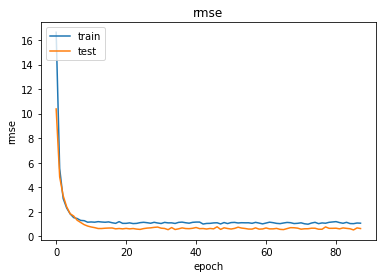

In [20]:
# plot training curve for rmse
plt.plot(result.history['rmse'])
plt.plot(result.history['val_rmse'])
plt.title('rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## **Third model**

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input,Dense
from keras.models import Model
import keras

In [37]:
dataset = pd.read_csv("Pantheon.csv")

dataset.head()

,Name,zcmb,zhel,dz,mb,dmb
0,03D1au,0.50309,0.50309,0.0,22.93445,0.12605
1,03D1ax,0.49480,0.49480,0.0,22.88020,0.11765
2,03D1co,0.67767,0.67767,0.0,24.03770,0.20560
3,03D1ew,0.86650,0.86650,0.0,24.34685,0.17385
4,03D1fq,0.79857,0.79857,0.0,24.36050,0.17435


In [38]:
dataset = dataset.drop(['dz', 'zhel', 'Name'], axis=1)
dataset.head()

,zcmb,mb,dmb
0,0.50309,22.93445,0.12605
1,0.49480,22.88020,0.11765
2,0.67767,24.03770,0.20560
3,0.86650,24.34685,0.17385
4,0.79857,24.36050,0.17435


In [39]:
y = dataset['mb']
X = dataset.drop('mb',axis=1)

In [40]:
from sklearn.model_selection import train_test_split

x_train , x_test , y_train , y_test = train_test_split(X, y,test_size=0.33)

In [41]:
N , D =x_train.shape
print(x_train.shape)
print('N',N)
print('D',D)

(684, 2)
N 684
D 2


In [42]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [43]:
myInput=Input(shape=(D,))
Dense1=Dense(128, activation = 'relu', kernel_initializer='normal')(myInput)
Dense2=Dense(64, activation = 'relu', kernel_initializer='normal')(Dense1)
Dense3=Dense(16, activation = 'relu', kernel_initializer='normal')(Dense2)
out_layer=Dense(1 , activation = 'linear')(Dense3)

model=Model(myInput,out_layer)

In [44]:
from keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(monitor="mean_squared_error", patience=40, verbose=1, mode='auto')


def lr_scheduler(epoch, lr):
    decay_rate = 0.1
    decay_step = 90
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr


callbacks = [keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1), earlystopping]

In [45]:
model.compile(optimizer='rmsprop',loss='mean_squared_error', metrics=['mean_absolute_error', 'mean_squared_error'])

In [ ]:
%%time
bc = model.fit(x_train , y_train , validation_split=0.2,epochs=100, callbacks=[callbacks])

In [47]:
%%time
model.evaluate(x_test, y_test)

11/11 [==============================] - 0s 2ms/step - loss: 0.0389 - mean_absolute_error: 0.1416 - mean_squared_error: 0.0389
CPU times: user 67.1 ms, sys: 1.67 ms, total: 68.7 ms
Wall time: 70.2 ms


[0.03889113664627075, 0.14163731038570404, 0.03889113664627075]

In [33]:
history = bc.history

In [34]:
history.keys()

dict_keys(['loss', 'mean_absolute_error', 'mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_mean_squared_error', 'lr'])

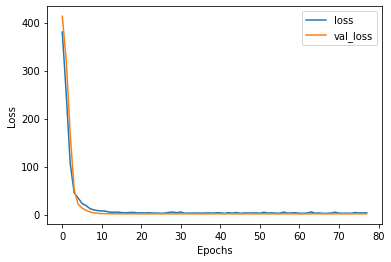

In [35]:
losses = history['loss']
val_losses = history['val_loss']
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(val_losses)
plt.plot(losses)
plt.legend(['loss','val_loss'])
plt.show()

# **Discussion**

1. اگر در هر یک از مدل ها، تعداد دفعات بیشتر از یکبار مدل را فیت کنیم، به علت بزرگتر شدن وزنها مدل اورفیت میکند.

2. در این مدلها از
$kernel \, \, initializer$
ای استفاده شده است که بر اساس تابع توزیع نرمال مقداردهی اولیه آنها به وزن ها صورت میگیرید.

3. به دلیل اینکه دیتا پیچیدگی زیادی ندارد و برای مدل اورفیتینگ اتفاق نمیفتد، استفاده از لایه های
$drop \, \, out$
 و انواع
$regularization$
ها توصیه نمیشود.

4. در این مدل از متریک هایی استفاده شده که مرتبط با تسک
$regression$
باشد. 
$mean \, \, squered \,\, error$
،
$mean \, \, absolute \,\, error$
،
$root \, \, mean \, \, squered \,\, error$
از متریک های رایج این تسک میباشند.

# **Comparison**

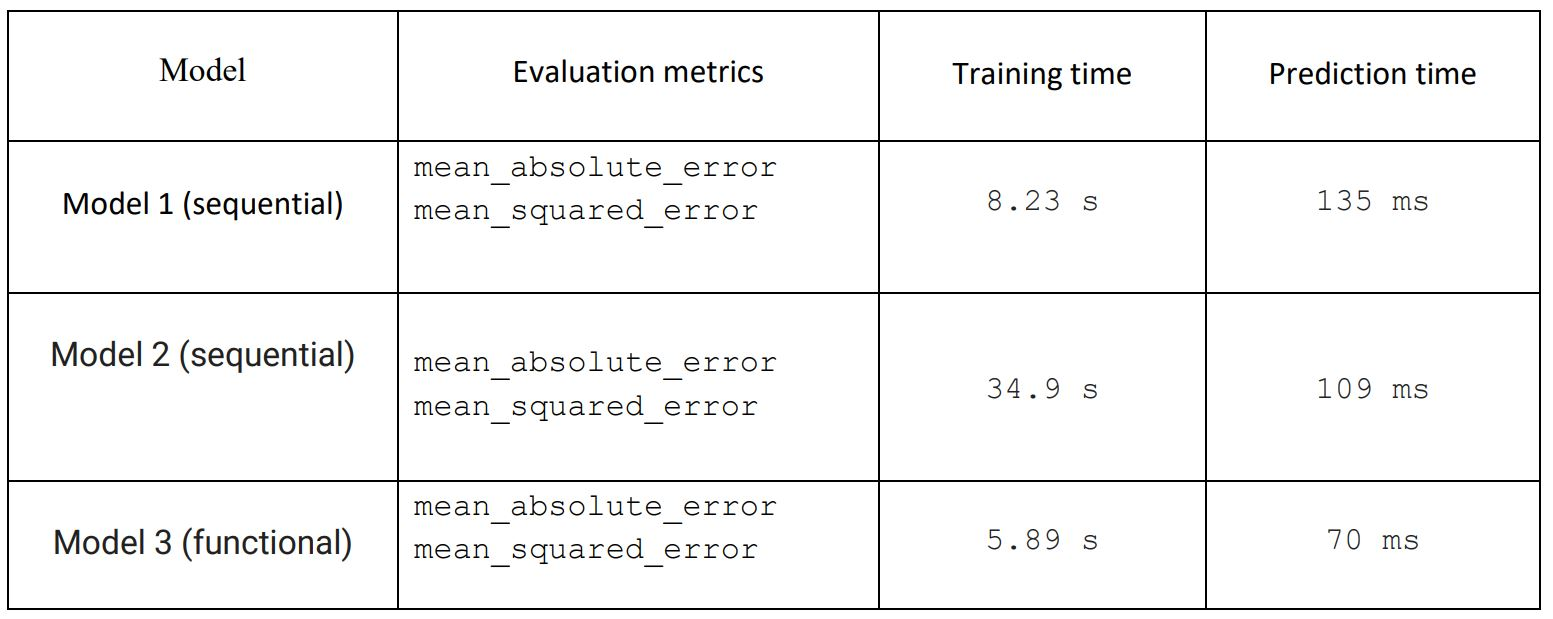